# Predict NYC Taxi Fares using ANN

The goal is to estimate the cost of a New York City cab ride from several inputs.The inspiration behind this code along is a recent <a href='https://www.kaggle.com/c/new-york-city-taxi-fare-prediction'>Kaggle competition</a>.

### STEPS:
1. Read the data  : only a portion from the 55 million dataset is used (120,000 records from April 11 to April 24, 2010.)
2. Features engineering :
 - Calculate distance
 - Derive useful data and time statistics
3.  Deal with categorical data 
 - Embedding
4. Use of TabularModel class to work with both continuous and categorical data
 - Create a TabularModel class
 - Add in loss function and optimizer
 - Train/test split the data
 - Train the model
 - Evaluate on test data
 - Predict on brand new data
 
    
        

In [1]:
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# read the data into a data frame
df= pd.read_csv("../Data/NYCTaxiFares.csv")
df.head(5)

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [3]:
# descrptive statistics on the fare amount
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

So, the average fare is \\$10.Minimum amount for a ride being \\$2.50 and maximum being \\$49.90 with a median of \\$7.70. 

In [4]:
# copy the dataframe to do feature engineering
df1 = df.copy()
df1.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


### Distance caluclation
Our goal is to predict the fares for a taxi ride in New York city. ususally it depends upon the distance. Here we have the longitudes and latitudes of the pickup and dropoff destinations. But these values look quite similar. To calculate the distance we will take the help of the <a href='https://en.wikipedia.org/wiki/Haversine_formula'>haversine formula</a> which calculates the distance on a sphere between two sets of GPS coordinates.<br>
Here we assign latitude values with $\varphi$ (phi) and longitude with $\lambda$ (lambda).

The distance formula works out to

${\displaystyle d=2r\arcsin \left({\sqrt {\sin ^{2}\left({\frac {\varphi _{2}-\varphi _{1}}{2}}\right)+\cos(\varphi _{1})\:\cos(\varphi _{2})\:\sin ^{2}\left({\frac {\lambda _{2}-\lambda _{1}}{2}}\right)}}\right)}$

where

$\begin{split} r&: \textrm {radius of the sphere (Earth's radius averages 6371 km)}\\
\varphi_1, \varphi_2&: \textrm {latitudes of point 1 and point 2 in radians}\\
\lambda_1, \lambda_2&: \textrm {longitudes of point 1 and point 2 in radians}\end{split}$

In [5]:
# define the haversine formula in a function
def haversine(df,long1,lat1,long2,lat2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in the dataframe df
    """
    # r = radius of earth in kms
    r = 6371
    
    # convert the longitude and latitude in radians
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    lambda1 = np.radians(df[long1])
    lambda2 = np. radians(df[long2])
    
    a = np.square(np.sin((phi2-phi1)/2))
    b = np.cos(phi1)* np.cos(phi2)* np.square((np.sin(lambda2-lambda1)/2))
    c = np.sqrt(a+b)
    d = 2*r* np.arcsin(c)
    
    return d

In [6]:
# Feature engineering the distance in Kms
df1['distance_kms'] = haversine(df1,'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude')
df1.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_kms
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231319


### Engineering the day and time

The time can also be an important predictor of the fare amount as it might vary on the weedays and peak hours. To evaluate this , we have to first convert it into a date time variable from a string.

In [7]:
# The datetime columns is string 
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
pickup_datetime      120000 non-null object
fare_amount          120000 non-null float64
fare_class           120000 non-null int64
pickup_longitude     120000 non-null float64
pickup_latitude      120000 non-null float64
dropoff_longitude    120000 non-null float64
dropoff_latitude     120000 non-null float64
passenger_count      120000 non-null int64
distance_kms         120000 non-null float64
dtypes: float64(6), int64(2), object(1)
memory usage: 8.2+ MB


In [8]:
df1['pickup_datetime'] = pd.to_datetime(df1['pickup_datetime'])
df1.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_kms
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231319


In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
pickup_datetime      120000 non-null datetime64[ns, UTC]
fare_amount          120000 non-null float64
fare_class           120000 non-null int64
pickup_longitude     120000 non-null float64
pickup_latitude      120000 non-null float64
dropoff_longitude    120000 non-null float64
dropoff_latitude     120000 non-null float64
passenger_count      120000 non-null int64
distance_kms         120000 non-null float64
dtypes: datetime64[ns, UTC](1), float64(6), int64(2)
memory usage: 8.2 MB


Now, the pickup_datetime is in data time format. It is represented in UTC format. As New York is in Eastern Time Zone, so we have to convert to ETD by substracting 3 more hours. Also, there is daylight savings between April 11 to 24th, 2010, so we will add one more hour to convert to ETD zone. 

We will also extract the day of travel and if that is during AM or PM  to evaluate the impact on the fare. 

In [10]:
df1['EDT_time'] = df1['pickup_datetime']-pd.Timedelta(hours =4)
df1.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_kms,EDT_time
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231319,2010-04-16 22:19:01+00:00


In [11]:
df1['day']=df1['EDT_time'].dt.strftime("%a")

In [12]:
df1['hour'] = df1['EDT_time'].dt.hour

In [13]:
df1['AMorPM'] = np.where(df1['hour']<12,'am','pm')
df1.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_kms,EDT_time,day,hour,AMorPM
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,Mon,4,am
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,Sat,11,am
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,Sat,7,am
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,Sun,17,pm
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231319,2010-04-16 22:19:01+00:00,Fri,22,pm


### Separate categorical from continuous columns

In [14]:
cat_cols = ['day','hour','AMorPM']
cont_cols = ['pickup_longitude','pickup_latitude', 'dropoff_longitude', 
             'dropoff_latitude','passenger_count', 'distance_kms']
y_col = ['fare_amount']

In [15]:
# Categirify : converting the  columns into categories 

In [16]:
for cat in cat_cols:
    df1[cat] = df1[cat].astype('category')

In [17]:
df1.dtypes

pickup_datetime      datetime64[ns, UTC]
fare_amount                      float64
fare_class                         int64
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
distance_kms                     float64
EDT_time             datetime64[ns, UTC]
day                             category
hour                            category
AMorPM                          category
dtype: object

The last three columns are now converted to categories.

In [18]:
df1['hour'].head()

0     4
1    11
2     7
3    17
4    22
Name: hour, dtype: category
Categories (24, int64): [0, 1, 2, 3, ..., 20, 21, 22, 23]

In [19]:
df1['day'].cat.codes

0         1
1         2
2         2
3         3
4         0
5         4
6         0
7         4
8         5
9         0
10        4
11        4
12        0
13        2
14        6
15        5
16        4
17        4
18        6
19        5
20        5
21        1
22        5
23        5
24        6
25        2
26        3
27        4
28        0
29        5
         ..
119970    3
119971    4
119972    0
119973    2
119974    2
119975    5
119976    5
119977    5
119978    3
119979    6
119980    6
119981    4
119982    6
119983    6
119984    0
119985    1
119986    0
119987    1
119988    3
119989    2
119990    3
119991    1
119992    0
119993    1
119994    3
119995    3
119996    0
119997    3
119998    5
119999    2
Length: 120000, dtype: int8

In [20]:
df1['AMorPM'].cat.categories

Index(['am', 'pm'], dtype='object')

So,we have hour divided in 24 , day in 7 and AMorPM in 2 categories. All these have been neumerically coded as well.
Next we convert these categories to numpy arrays so that in future we can use neural network. 

In [21]:
wkday = df1['day'].cat.codes.values
hr = df1['hour'].cat.codes.values
ampm = df1['AMorPM'].cat.codes.values


In [22]:
# Check one of the variable
hr

array([ 4, 11,  7, ..., 14,  4, 12], dtype=int8)

In [23]:
# stack these 
cats=np.stack([wkday,hr,ampm],axis =1)
cats[:5]

array([[ 1,  4,  0],
       [ 2, 11,  0],
       [ 2,  7,  0],
       [ 3, 17,  1],
       [ 0, 22,  1]], dtype=int8)

Now the three categorical variables are represented as a numpy array with each column representing each variable - hour, day and am/pm value.  

In [24]:
# Another way of doing it is using list comprehension
# cats = np.stack([df[col].cat.codes.values for col in cat_cols],1)

In [25]:
# convert category array to tensor
cats = torch.tensor(cats,dtype = torch.int64)
cats[:5]

tensor([[ 1,  4,  0],
        [ 2, 11,  0],
        [ 2,  7,  0],
        [ 3, 17,  1],
        [ 0, 22,  1]])

In [26]:
# shape of category tensor
cats.shape

torch.Size([120000, 3])

In [27]:
cats.type

<function Tensor.type>

In [28]:
# convert continuos list to a numpy array to tensor
conts = np.stack([df1[col].values for col in cont_cols],axis =1)
conts[:5]

array([[-73.992365  ,  40.730521  , -73.975499  ,  40.744746  ,
          1.        ,   2.12631158],
       [-73.990078  ,  40.740558  , -73.974232  ,  40.744114  ,
          1.        ,   1.39230685],
       [-73.994149  ,  40.751118  , -73.960064  ,  40.766235  ,
          2.        ,   3.32676333],
       [-73.990485  ,  40.756422  , -73.971205  ,  40.748192  ,
          1.        ,   1.86412923],
       [-73.990976  ,  40.734202  , -73.905956  ,  40.743115  ,
          1.        ,   7.23131908]])

In [29]:
# convert continuos array to tensor
conts = torch.tensor(conts, dtype = torch.float)

In [30]:
# shape of the continuos tensor
conts.shape

torch.Size([120000, 6])

In [31]:
# convert label to tensor
y = torch.tensor(df[y_col].values,dtype = torch.float).reshape(-1,1)
y[:5]

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        [ 8.9000],
        [19.7000]])

In [32]:
# shape of the label tensor
y.shape

torch.Size([120000, 1])

### Embedding

Embedding layer comes with PyTorch. It create a lookup table of fixed dictionary and size. We want to one hot encode the categories. 

### Set an embedding size
The rule of thumb for determining the embedding size is to divide the number of unique entries in each column by 2, but not to exceed 50.

In [33]:
# Create a list of how many categories we have in each column
cat_szs = [len(df1[col].cat.categories) for col in cat_cols] 
cat_szs

[7, 24, 2]

In [34]:
# Set embedding sizes for the columns by dividing the number of unique entries in each column by 2, but not to exceed 50.
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs] # two forwards slashes because we want int output as it will be thse shape of array
emb_szs # we get a list of tupules

[(7, 4), (24, 12), (2, 1)]

### Tabular Model

In [35]:
class TabularModel(nn.Module):
    
    def __init__(self,emb_szs,n_cont, out_sz, layers, p=0.5):
        
        # emb_szs - tupules - each categorical variable size is paired with an embedding size
        # n_cont - number of continuous features
        # Out_sz - output size = 1 as this is a regression problem
        # layers - A list of number of neurons in each layer - can take any value for each layer and makes the network flexible
        # p = probality for droupout layer defaulted  to 0.5
        
        super().__init__()
        
        #Create a list of the embedding layers 
        #Categorical data will be filtered through these Embeddings in the forward section.
        self.embeds = nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in emb_szs]) 
        
        #Set up a dropout function for the embeddings with torch.nn.Dropout() The default p-value=0.5
        # randomly turns off p percent of neurons  to avoid overfitting
        self.emb_drop = nn.Dropout(p)
        
        #Set up a normalization function for the continuous variables with torch.nn.BatchNorm1d() 
        # to make sure all the data is within same manitude range
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        #Set up a sequence of neural network layers where each level includes a Linear function,
        # an activation function (we'll use ReLU), a normalization step, and a dropout layer. 
        # We'll combine the list of layers with torch.nn.Sequential()
        
        
        layerlist = [] # list to store layers
        n_emb = sum([nf for ni, nf in emb_szs]) # number of total embeddings
        n_in = n_emb + n_cont # total number of in features
        
        # setup the neural network layers
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) # A linear function layer with n_in as input feature and i as output feature
            layerlist.append(nn.ReLU(inplace = True)) # Activation function 
            layerlist.append(nn.BatchNorm1d(i))# add the normalization process
            layerlist.append(nn.Dropout(p)) #drop based on probality p
            n_in =i
            
        layerlist.append(nn.Linear(layers[-1],out_sz)) # output layer
        
        self.layers = nn.Sequential(*layerlist) # combine all the layers together
            
    
    def forward(self,x_cat,x_cont):
        
        # Define the forward method by passing :
        # x_cat = categorical features
        # x_cont = continuous features. 
        
        # Preprocess the embeddings and normalize the continuous variables 
        # before passing them through the layers.

        embeddings =[] # A placeholder list for embeddings
        
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i])) # create the embedding list by adding values
       
        x = torch.cat(embeddings, 1) # x is the output and concatenating it across the different categories
        x = self.emb_drop(x)
        x_cont = self.bn_cont(x_cont)
        
        # Use torch.cat() to combine multiple tensors into one.
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        
        return x

In [36]:
# Instantiate and Evaluate the model class by specifying the manual_seed
torch.manual_seed(33)
# we need to define the different variables required to passed into the class 
# n_cont - number of continuous features = no. of columns in the  continuos tensor - cont
# Out_sz - output size = 1 as this is a regression problem
# layers - A list of number of neurons in each layer - we have made a NN of two hidden layers with 200 and 150  neurons respectively
# p = probality for droupout layer defaulted  to 0.5 - we have set here 0.4
model = TabularModel(emb_szs, n_cont = conts.shape[1],out_sz= 1, layers = [250,150], p =0.4 )
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(7, 4)
    (1): Embedding(24, 12)
    (2): Embedding(2, 1)
  )
  (emb_drop): Dropout(p=0.4)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=250, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4)
    (4): Linear(in_features=250, out_features=150, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4)
    (8): Linear(in_features=150, out_features=1, bias=True)
  )
)

So, we have intantiated the model by providing the required inputs. This results in a model with 
- embeds - a list of the embedding layers 
- emb_drop - dropdout value is set to 0.4
- bn_cont - batch normalization is applied to the continous tensor
- layers - Three hidden layers have been created and put together by sequential - 
           - In first hidden layer, no. of neurons input is 23(4+12+1+6) and no. of neurons going out is 200 (the                   value we provided)
           - In second hidden layer, in_features=200, out_features=100
           - In the third hidden layer , in_features=100, out_features=50
           - Final output layer has in_features=50, out_features=1
In every unit of every layer , these steps are performed:
- A linear transformation is applied to the incoming data
- the rectified linear unit function is applied element-wise and inplace
- then Batch Normalization is applied over the output feature to increase the stability of a neural network.  This normalizes the output of a previous activation layer by subtracting the batch mean and dividing by the batch standard deviation.
- finally, randomly some of the elements of the input tensor with probability p using samples from a Bernoulli distribution are zeroed during training. Each channel will be zeroed out independently on every forward call.This has proven to be an effective technique for regularization and preventing the co-adaptation of neurons. 


### Add loss function and opimizer

PyTorch does not offer a built-in RMSE Loss function, so, we'll simply apply the torch.sqrt() function to the output of MSELoss during training.

We will use Adam optimizer

In [37]:
criterion = nn.MSELoss()  # we'll convert this to RMSE later
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Perform train/test splits

In [38]:
batch_size = 60000
test_size = int(batch_size * .2)

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]


In [39]:
len(cat_train)

48000

In [40]:
cat_train[:5]

tensor([[ 1,  4,  0],
        [ 2, 11,  0],
        [ 2,  7,  0],
        [ 3, 17,  1],
        [ 0, 22,  1]])

In [41]:
len(cat_test)

12000

### Train the model

In [42]:
import time
start_time = time.time()

epochs = 500
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train)) # RMSE
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {(time.time() - start_time)/60:.0f} minutes') # print the time elapsed

epoch:   1  loss: 12.59131908
epoch:  26  loss: 11.19176865
epoch:  51  loss: 10.05479717
epoch:  76  loss: 9.24247169
epoch: 101  loss: 8.29934978
epoch: 126  loss: 7.03030157
epoch: 151  loss: 5.48410463
epoch: 176  loss: 4.07823896
epoch: 201  loss: 3.49155474
epoch: 226  loss: 3.40820932
epoch: 251  loss: 3.36421084
epoch: 276  loss: 3.33104229
epoch: 301  loss: 3.30691695
epoch: 326  loss: 3.25294924
epoch: 351  loss: 3.25117254
epoch: 376  loss: 3.23143816
epoch: 401  loss: 3.22345281
epoch: 426  loss: 3.21656156
epoch: 451  loss: 3.19693732
epoch: 476  loss: 3.19142056
epoch: 500  loss: 3.16560078

Duration: 44 minutes


### Plot the loss function

Text(0, 0.5, 'RMSE loss')

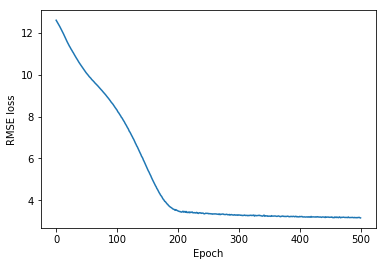

In [43]:
plt.plot(range(epochs),losses)
plt.xlabel('Epoch')
plt.ylabel('RMSE loss')

### Validate the model
Here we want to run the entire test set through the model, and compare it to the known labels.
For this step we don't want to update weights and biases, so we set torch.no_grad()

In [44]:
with torch.no_grad():
    y_val = model (cat_test,con_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')   

RMSE: 3.12279606


In [45]:
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in range(10):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'{i+1:2}. {y_val[i].item():8.4f} {y_test[i].item():8.4f} {diff:8.4f}')

   PREDICTED   ACTUAL     DIFF
 1.   3.2200   2.9000   0.3200
 2.  21.0911   5.7000  15.3911
 3.   5.5878   7.7000   2.1122
 4.  11.9447  12.5000   0.5553
 5.   4.2048   4.1000   0.1048
 6.   6.3432   5.3000   1.0432
 7.   4.6100   3.7000   0.9100
 8.  18.3221  14.5000   3.8221
 9.   4.1190   5.7000   1.5810
10.  14.3831  10.1000   4.2831
